# "I'm The King of the World! Or Almost...". Predicting Titanic Passengers' Fate through Machine Learning

# Introduction

"What sort of people were more likely to survive?"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# Loading the Data

In [2]:
# Reading in the datasets
train_df = pd.read_csv("~/Desktop/my_projects//data/titanic_data/train.csv")
test_df = pd.read_csv("~/Desktop/my_projects//data/titanic_data/train.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Dealing With Missing Values

In [3]:
# Creating a function that identifies and plots missing values
def missingdata(data):
    total = (
        data.isnull().sum().sort_values(ascending=False)
    )  # summing all the null values in the dataset and sorting them in descending order
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(
        ascending=False
    )  # calculating the percentage of the missing values in each feature
    ms = pd.concat(
        [total, percent], axis=1, keys=["Total", "Percent"]
    )  # concatenating the total and the percentage missing values in a table
    ms = ms[
        ms["Percent"] > 0
    ]  # returning only those missing values which have a percentage greater than 0
    # plotting the missing data
    f, ax = plt.subplots(figsize=(8, 6))
    plt.xticks(rotation="90")  # setting the rotation of the x ticks to 90 degrees
    fig = sns.barplot(
        ms.index, ms["Percent"], color="green", alpha=0.8
    )  # creating green barplots
    plt.xlabel("Features", fontsize=15)  # adding a label on the x axis
    plt.ylabel("Percent of missing values", fontsize=15)  # adding a label on the y axis
    plt.title(
        "Percent missing data by feature", fontsize=15
    )  # adding a title to the graph
    return ms

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


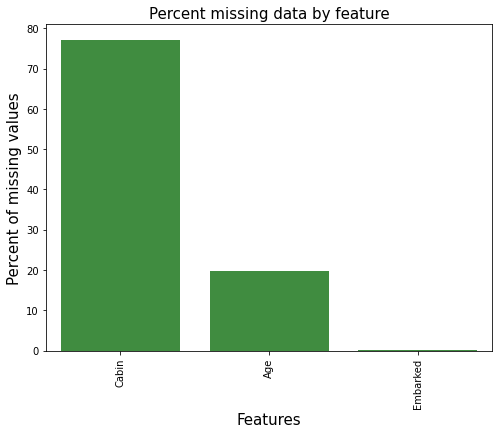

In [4]:
# Identifying missing values in the training set
missingdata(train_df)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


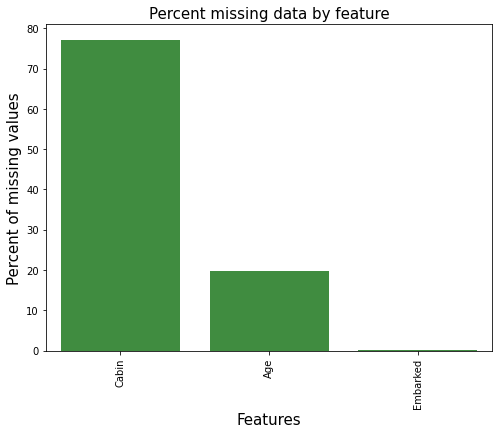

In [5]:
missingdata(test_df)

## Dealing With Missing Values in the Training Set

In [6]:
# Filling missing values in the training set
train_df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace=True)
train_df["Age"].fillna(train_df["Age"].median(), inplace=True)

# Dropping columns with too many missing values or that are not necessary
drop_column_training_set = ["Cabin", "Ticket"]
train_df.drop(drop_column_training_set, axis=1, inplace=True)

## Dealing With Missing Values in the Test Set

In [7]:
# Using the training set medians to substitute test set NaNs in order to prevent any biases
test_df["Age"].fillna(train_df["Age"].median(), inplace=True)
test_df["Fare"].fillna(train_df["Fare"].median(), inplace=True)

# Dropping unnecessary columns
drop_column_test_set = ["Cabin", "Ticket"]
test_df.drop(drop_column_test_set, axis=1, inplace=True)

In [8]:
print("check the nan value in train data")
print(train_df.isnull().sum())
print("___" * 30)
print("check the nan value in test data")
print(test_df.isnull().sum())

check the nan value in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
__________________________________________________________________________________________
check the nan value in test data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64


# Feature Engineering

In [9]:
# Combining test and train as single to apply some function
all_data = [train_df, test_df]

## The FamilySize Feature 

In [10]:
# Creating a new feature called FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

# Dropping SibSp and Parch
drop_column = ["SibSp", "Parch"]

for dataset in all_data:
    dataset.drop(drop_column, axis=1, inplace=True)

## The Title Feature 

In [11]:
# Creating a new Title feature extracting from existing ones
for dataset in all_data:
    dataset["Title"] = dataset.Name.str.extract(
        " ([A-Za-z]+)\.", expand=False
    )  # Extracting the titles from the name column and adding them to a new column called 'Title' - using a regex to extract any word with a dot after it
    dataset["Title"] = dataset["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
            "Master",
        ],
        "Rare",
    )  # replacing rare titles with the word 'Rare'
    dataset["Title"] = dataset["Title"].replace(
        "Mlle", "Miss"
    )  # replacing other titles with more common ones
    dataset["Title"] = dataset["Title"].replace(
        "Ms", "Miss"
    )  # replacing other titles with more common ones
    dataset["Title"] = dataset["Title"].replace(
        "Mme", "Mrs"
    )  # replacing other titles with more common ones

# Dropping the Name column as we don't need it anymore
drop_columns = ["Name"]
for dataset in all_data:
    dataset.drop(drop_columns, axis=1, inplace=True)

In [12]:
# Converting the categorical titles to ordinal
title_mapping = {
    "Mr": 1,
    "Miss": 2,
    "Mrs": 3,
    "Rare": 4,
}  # creating a dictionary of all the titles as key and their ordinal number as value

for dataset in all_data:
    dataset["Title"] = dataset["Title"].map(
        title_mapping
    )  # transforming each title into ordinal through the map function

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,male,22.0,7.2500,S,2,1
1,2,1,1,female,38.0,71.2833,C,2,3
2,3,1,3,female,26.0,7.9250,S,1,2
3,4,1,1,female,35.0,53.1000,S,2,3
4,5,0,3,male,35.0,8.0500,S,1,1


## The Sex Feature

In [13]:
# Converting the sex feature which contain strings to numerical values
for dataset in all_data:
    dataset["Sex"] = (
        dataset["Sex"].map({"female": 1, "male": 0}).astype(int)
    )  # changing the data type from string to integer

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,0,22.0,7.2500,S,2,1
1,2,1,1,1,38.0,71.2833,C,2,3
2,3,1,3,1,26.0,7.9250,S,1,2
3,4,1,1,1,35.0,53.1000,S,2,3
4,5,0,3,0,35.0,8.0500,S,1,1


## The Age Feature

In [ ]:
# Creating bins for age features
for dataset in all_data:
    dataset["Age Bin"] = pd.cut(dataset["Age"], bins=[0, 16, 32, 48, 64])

for dataset in all_data:
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4

In [17]:
train_df['Age'].dtype

dtype('float64')

In [ ]:
# Dropping the Age Bin column as we don't need it anymore
drop_columns = ["Age Bin"]
for dataset in all_data:
    dataset.drop(drop_columns, axis=1, inplace=True)

train_df.head()

## The Fare Feature

In [ ]:
for dataset in all_data:
    dataset["Fare"] = dataset["Fare"].round(
        1
    )  # Rounding off the Fare feature to two decimal places
    dataset["Fare Bin"] = pd.cut(
        dataset["Fare"],
        bins=[0, 7.91, 14.45, 31, 120],
        labels=["Low Fare", "Median Fare", "Average Fare", "High Fare"],
    )  # Creating bins for fare features
# Converting the Fare feature into ordinal values depending on its bins
for dataset in all_data:
    dataset.loc[dataset["Fare"] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)

# Dropping the Fare Bin column as we don't need it anymore
drop_columns = ["Fare Bin"]
for dataset in all_data:
    dataset.drop(drop_columns, axis=1, inplace=True)
    
train_df.head()

## The Embarked Feature 

In [ ]:
# Converting the categorical feature of Embarked to numeric
for dataset in all_data:
    dataset["Embarked"] = dataset["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)

train_df.head()

In [ ]:
# Making a copy of both datasets and starting to work for the copy of the datasets
copy_train_df = train_df
copy_test_df = test_df

In [ ]:
combined = [copy_train_df, copy_test_df]

In [ ]:
train_df.columns.tolist()

# Training Our Machine Learning Model 

## Applying Feature Selection Using Sequential Feature Selector

In [ ]:
# Splitting training set into 75% training and 25% validation to check the model performance before submitting final results
from sklearn.model_selection import train_test_split

X_train = train_df.drop("Survived", axis=1)  # assigning the training data to a variable named X_train and dropping the Survived column (the value that we want to predict)
Y_train = train_df["Survived"]  # assigning the value that we want to predict to Y_train

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=1
)  # taking in X_train and Y_train and splitting them with a ratio of 75% and 25% and outputs a new X_train, a new X_val, a new Y_train, and a new Y_val

In [ ]:
x_features = ['Pclass'] # Select an initial feature 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()

In [ ]:
# model is f, where x is info we already know (the features) and the output f(x) (e.g., x**2) is the prediction. 
# to train the model (i.e. figure out what the function f is) we need the training x and y.
# what we want to minimise is the error between [y_train (i.e., the true value) and f(x_train)]. which are both true and happened in the past.
model.fit(X_train[x_features], Y_train) 

In [ ]:
y_val_preds = model.predict(X_val[x_features]) # we compute the model output of the validation set (i.e., Y_val_PRED) using the X_val features 

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(Y_val, y_val_preds) # compare the predicted value of Y_val_PRED with the actual Y_Val (the true value)

In [ ]:
# for each set there is always the y that is true and the y that is predicted

In [ ]:
all_features = [ 
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'Embarked',
    'FamilySize',
    'Title'
]

In [ ]:
features_to_use = [] # creating an empty list to store the feature to use to train the model 

while len(all_features) > 0: # as long as there is at least one value in all the features' list, ...  
    
    feature_performance = {} # creating an empty dictionary to store the feature as key and its performance as value 
    
    for feature in all_features: # looping over all the features in the feature list 
        model = RandomForestClassifier() # training the model 
        model.fit(X_train[features_to_use + [feature]], Y_train) # fitting the model with the feature_to_use and the feature we are iterating through in X_train, giving it Y_train
        y_val_preds = model.predict(X_val[features_to_use + [feature]]) # predicting the y_val_pred by using the feature_to_use and the feature of the X_Val
        feature_performance[feature] = accuracy_score(Y_val, y_val_preds) # computing the accuracy score of the true value Y_val and its prediction y_val_pred and assigning it to the dictionary where the feature is the key 
    
    feature_max = max(feature_performance, key=feature_performance.get) # extracting the feature which scored highest in performance 
    features_to_use.append(feature_max) # appending the feature which scored the highest to the feature_to_use list 
    all_features.remove(feature_max) # removing the previous maximum feature that we used 
    print(features_to_use, max(feature_performance.values()))
    
    

In [ ]:
best_features = ['Sex', 'Fare', 'Pclass', 'FamilySize']

In [ ]:
best_model = RandomForestClassifier()

best_model.fit(copy_train_df[best_features], copy_train_df["Survived"])

In [ ]:
y_test_preds = best_model.predict(copy_test_df[best_features])

In [ ]:
output = pd.DataFrame({"PassengerId": copy_test_df.PassengerId, "Survived": y_test_preds})
output.to_csv("submission.csv", index=False)